In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import FID_util
import matplotlib.pyplot as plt

# Set seed here
import numpy as np
seed = 123459
np.random.seed(seed)
torch.manual_seed(seed)

## Data Sets

In [2]:
CIFAR_train_loader = DataLoader(datasets.CIFAR10('./data', train=True, download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True)

CIFAR_train = FID_util.load_data_single(CIFAR_train_loader, 1000, (32, 32))
CIFAR_generated = FID_util.load_from_dir("./generated_images/cifar_generated/*.png")
print(f"Base FID CIFAR-10: {FID_util.compute_FID(CIFAR_train, CIFAR_generated).item()}")

Files already downloaded and verified
Base FID CIFAR-10: 0.5221002697944641


In [3]:
CelebA_train = FID_util.load_from_dir("./data/celeba_hq_256/*.jpg", seed)
CelebA_generated = FID_util.load_from_dir("./generated_images/celebA_generated/*.png")
print(f"Base FID CelebA-HQ: {FID_util.compute_FID(CelebA_train, CelebA_generated).item()}")

Base FID CelebA-HQ: 5.398116588592529


## Gamma Correction

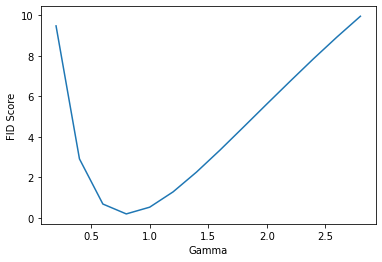

In [4]:
gamma_array = np.arange(0.2, 3.0, 0.2)
FID_util.plot_FID(gamma_array, transforms.functional.adjust_gamma, "Gamma", CIFAR_train, CIFAR_generated)
plt.savefig("plots/diffusion_image_graphs/g_CIFAR_gamma_fid_scores")

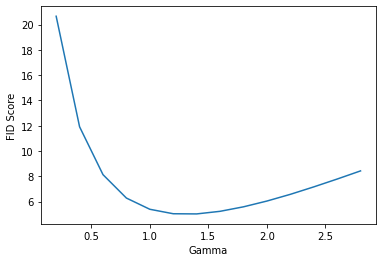

In [5]:
FID_util.plot_FID(gamma_array, transforms.functional.adjust_gamma, "Gamma", CelebA_train, CelebA_generated)
plt.savefig("plots/diffusion_image_graphs/g_CelebA_gamma_fid_scores")

## Image Saturation

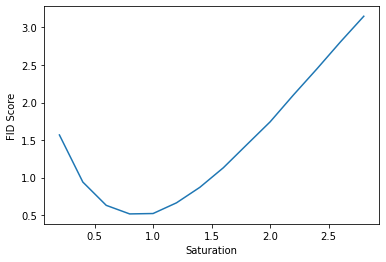

In [6]:
level_array = np.arange(0.2, 3.0, 0.2)
FID_util.plot_FID(level_array, transforms.functional.adjust_saturation, "Saturation", CIFAR_train, CIFAR_generated)
plt.savefig("plots/diffusion_image_graphs/g_CIFAR_saturation_fid_scores")

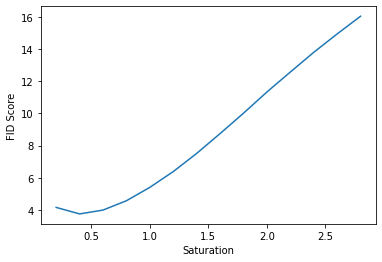

In [7]:
FID_util.plot_FID(level_array, transforms.functional.adjust_saturation, "Saturation", CelebA_train, CelebA_generated)
plt.savefig("plots/diffusion_image_graphs/g_CelebA_saturation_fid_scores")

## Image Sharpening

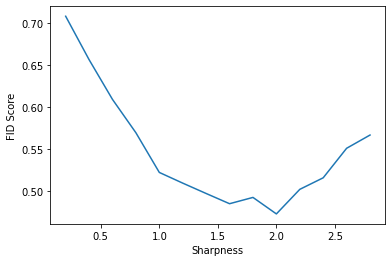

In [8]:
level_array = np.arange(0.2, 3.0, 0.2)
FID_util.plot_FID(level_array, transforms.functional.adjust_sharpness, "Sharpness", CIFAR_train, CIFAR_generated)
plt.savefig("plots/diffusion_image_graphs/g_CIFAR_sharpness_fid_scores")

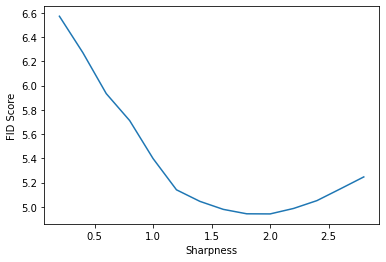

In [9]:
FID_util.plot_FID(level_array, transforms.functional.adjust_sharpness, "Sharpness", CelebA_train, CelebA_generated)
plt.savefig("plots/diffusion_image_graphs/g_CelebA_sharpness_fid_scores")

## Salt and Pepper Noise

In [10]:
from skimage.util import random_noise
def noisify_FID(amount, dataset_train, dataset_test, print_pic=False, seed=128):
    noised_test = torch.clone(dataset_test)
    noised_test = torch.tensor(random_noise(noised_test, mode="s&p", rng=seed, amount=amount))
    noised_test = noised_test*255
    noised_test = noised_test.type(torch.uint8)
    if print_pic:
        display = transforms.functional.to_pil_image(noised_test[1])
        plt.imshow(display)
    return FID_util.compute_FID(dataset_train, noised_test).item()

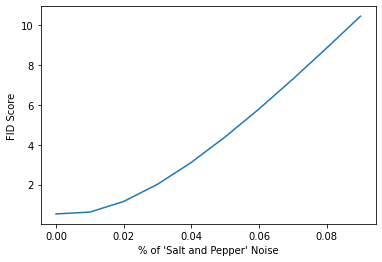

In [11]:
percentages = np.arange(0, 0.1, 0.01)
noise_FID_results = [noisify_FID(p, CIFAR_train, CIFAR_generated, seed=seed) for p in percentages]
plt.plot(percentages, noise_FID_results)
plt.xlabel("% of 'Salt and Pepper' Noise")
plt.ylabel("FID Score")
plt.savefig("plots/diffusion_image_graphs/g_CIFAR_Noise_fid_scores")

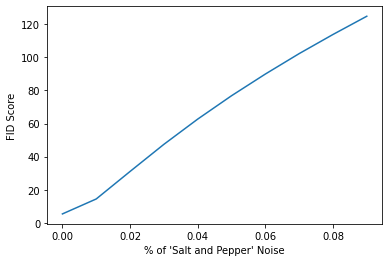

In [12]:
noise_FID_results = [noisify_FID(p, CelebA_train, CelebA_generated, seed=seed) for p in percentages]
plt.plot(percentages, noise_FID_results)
plt.xlabel("% of 'Salt and Pepper' Noise")
plt.ylabel("FID Score")
plt.savefig("plots/diffusion_image_graphs/g_CelebA_Noise_fid_scores")

## Rotations

## Gaussian Blur

In [13]:
import seaborn as sns
from itertools import product

def generate_heatmap(dataset_train, dataset_test, dataset):
    kernel_sizes = np.arange(1, 13, 2)
    coords = np.array(list(product(kernel_sizes, kernel_sizes)))
    heat_matrix = np.zeros((6, 6))
    for c in coords:
        heat_matrix[c[0]//2, c[1]//2] = FID_util.compute_transform_FID(
        transforms.functional.gaussian_blur, tuple(c), dataset_train, dataset_test)
    plot = sns.heatmap(heat_matrix, annot=True, xticklabels=kernel_sizes, yticklabels=kernel_sizes, cmap=sns.diverging_palette(220, 20, as_cmap=True))
    plot.get_figure().savefig('plots/' + dataset + '_blurring_FID.png', dpi=400)
    return None

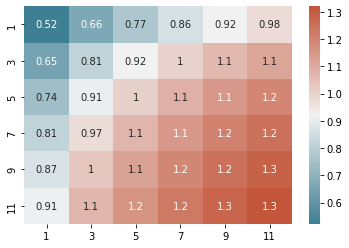

In [14]:
generate_heatmap(CIFAR_train, CIFAR_generated, "diffusion_image_graphs/g_CIFAR")

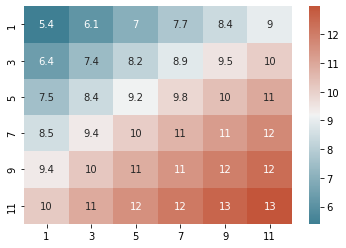

In [15]:
generate_heatmap(CelebA_train, CelebA_generated, "diffusion_image_graphs/g_CelebA")